In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np

# load MATLAB file
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
from urllib import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num = 1, block_size = 1, total_size = None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit = 'B', unit_scale = True, miniters = 1, desc = 'SVHN Training Set') as pbar:
        urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', data_dir + 'train_32x32.mat', pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit = 'B', unit_scale = True, miniters = 1, desc = 'SVHN Testing Set') as pbar:
        urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', data_dir + 'test_32x32.mat', pbar.hook)

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
trainset = np.rollaxis(trainset['X'][:,:,:,:], 3)
trainset.shape

(73257, 32, 32, 3)

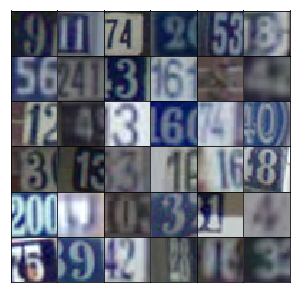

In [5]:
idx = np.random.randint(0, trainset.shape[0], size = 36)
fig, axes = plt.subplots(6, 6, sharex = True, sharey = True, figsize = (5,5))

for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset[ii,:,:,:], aspect = 'equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plt.subplots_adjust(wspace = 0, hspace = 0)

In [6]:
def first_scale(x, feature_range = (-1, 1)):
    x = ((x - x.min())/(255 - x.min()))
    min, max = feature_range
    x = x * (max - min) + min
    return x

def first_originate(x):
    return ((x - x.min()) * 255 / (x.max() - x.min()))

def second_scale(x):
    return x / 255.0

def second_originate(x):
    return (x * 255).astype(np.uint8)

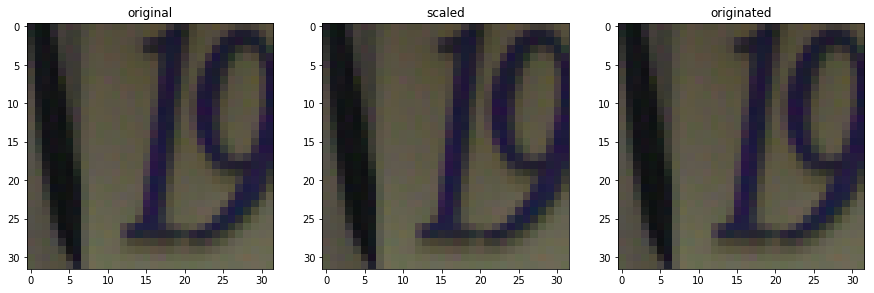

In [7]:
scaled_image = second_scale(trainset[0,:,:,:])

fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(trainset[0,:,:,:])
plt.title('original')
plt.subplot(1, 3, 2)
plt.imshow(scaled_image)
plt.title('scaled')
plt.subplot(1, 3, 3)
plt.imshow(second_originate(scaled_image))
plt.title('originated')

In [8]:
def view_samples(epoch, samples, nrows, ncols, figsize = (5,5)):
    fig, axes = plt.subplots(figsize = figsize, nrows = nrows, ncols = ncols, sharey = True, sharex = True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect = 'equal')
   
    plt.subplots_adjust(wspace = 0, hspace = 0)
    return fig, axes

In [9]:
class Model:
    
    def __init__(self, z_dim, learning_rate = 0.0001, beta = 0.5, alpha = 0.2):
        
        self.inputs = tf.placeholder(tf.float32, (None, 32, 32, 3))
        self.Z = tf.placeholder(tf.float32, (None, z_dim))
        
        def generator(z, reuse = False, alpha = 0.2, training = True):
            
            with tf.variable_scope('generator', reuse = reuse):
                x1 = tf.layers.dense(z, 4 * 4 * 512)
                x1 = tf.reshape(x1, (-1, 4, 4, 512))
                x1 = tf.layers.batch_normalization(x1, training = training)
                x1 = tf.maximum(alpha * x1, x1)

                x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
                x2 = tf.layers.batch_normalization(x2, training = training)
                x2 = tf.maximum(alpha * x2, x2)
        
                x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
                x3 = tf.layers.batch_normalization(x3, training = training)
                x3 = tf.maximum(alpha * x3, x3)

                logits = tf.layers.conv2d_transpose(x3, 3, 5, strides = 2, padding = 'same')
        
                return tf.sigmoid(logits)
        
        def discriminator(x, reuse = False, alpha = 0.2):
    
            with tf.variable_scope('discriminator', reuse = reuse):
                x1 = tf.layers.conv2d(x, 64, 5, strides = 2, padding = 'same')
                relu1 = tf.maximum(alpha * x1, x1)
        
                x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
                bn2 = tf.layers.batch_normalization(x2, training=True)
                relu2 = tf.maximum(alpha * bn2, bn2)
        
                x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
                bn3 = tf.layers.batch_normalization(x3, training = True)
                relu3 = tf.maximum(alpha * bn3, bn3)

                flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
                logits = tf.layers.dense(flat, 1)
                out = tf.sigmoid(logits)
        
                return out, logits
        
        g_model = generator(self.Z, alpha = alpha)
        self.g_out = generator(self.Z, reuse = True, training = False)
        d_model_real, d_logits_real = discriminator(self.inputs, alpha = alpha)
        d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha = alpha)

        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))

        self.d_loss = d_loss_real + d_loss_fake
        
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta).minimize(self.d_loss, var_list = d_vars)
            self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta).minimize(self.g_loss, var_list = g_vars)

In [10]:
sess = tf.InteractiveSession()
model = Model(100)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [11]:
sample_z = np.random.uniform(-1, 1, size = (72, 100))

try:
    saver.restore(sess, './checkpoints/generator.ckpt')
except Exception as e:
    BATCH_SIZE = 128
    EPOCH = 20
    samples, losses = [], []

    for i in xrange(EPOCH):
        loss_G = 0; loss_D = 0 
        for x in xrange(0, trainset.shape[0] - BATCH_SIZE, BATCH_SIZE):
            batch_z = np.random.uniform(-1, 1, size = (BATCH_SIZE, 100))
            _, lossd = sess.run([model.d_train_opt, model.d_loss], feed_dict = {model.inputs: second_scale(trainset[x: x + BATCH_SIZE, :, :, :]), model.Z: batch_z})
            _, lossg = sess.run([model.g_train_opt, model.g_loss], feed_dict = {model.Z: batch_z, model.inputs: second_scale(trainset[x: x + BATCH_SIZE, :, :, :])})
            loss_D += lossd; loss_G += lossg
        
        loss_D /= ((trainset.shape[0] - BATCH_SIZE) / BATCH_SIZE)
        loss_G /= ((trainset.shape[0] - BATCH_SIZE) / BATCH_SIZE)
        losses.append((loss_D, loss_G))
        print("Epoch {}/{}...".format(i + 1, EPOCH),
                    "Discriminator Loss: {:.4f}".format(loss_D),
                    "Generator Loss: {:.4f}".format(loss_G))
        saver.save(sess, './checkpoints/generator.ckpt')

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt
('Epoch 1/20...', 'Discriminator Loss: 0.9371', 'Generator Loss: 2.1929')
('Epoch 2/20...', 'Discriminator Loss: 1.3532', 'Generator Loss: 1.0044')
('Epoch 3/20...', 'Discriminator Loss: 1.3754', 'Generator Loss: 0.8787')
('Epoch 4/20...', 'Discriminator Loss: 1.3039', 'Generator Loss: 0.9360')
('Epoch 5/20...', 'Discriminator Loss: 1.2485', 'Generator Loss: 1.0031')
('Epoch 6/20...', 'Discriminator Loss: 1.1370', 'Generator Loss: 1.1213')
('Epoch 7/20...', 'Discriminator Loss: 1.1020', 'Generator Loss: 1.1801')
('Epoch 8/20...', 'Discriminator Loss: 1.1045', 'Generator Loss: 1.1634')
('Epoch 9/20...', 'Discriminator Loss: 1.0821', 'Generator Loss: 1.1978')
('Epoch 10/20...', 'Discriminator Loss: 1.0719', 'Generator Loss: 1.2096')
('Epoch 11/20...', 'Discriminator Loss: 1.0536', 'Generator Loss: 1.2284')
('Epoch 12/20...', 'Discriminator Loss: 1.0283', 'Generator Loss: 1.2802')
('Epoch 13/20...', 'Discriminator Loss

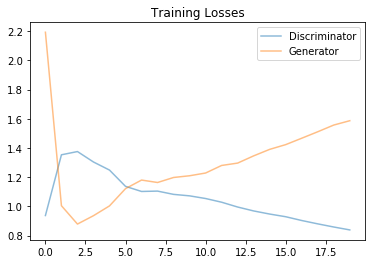

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label = 'Discriminator', alpha = 0.5)
plt.plot(losses.T[1], label = 'Generator', alpha = 0.5)
plt.title("Training Losses")
plt.legend()

In [13]:
outputs = sess.run(model.g_out, feed_dict = {model.Z: sample_z})
outputs.shape

(72, 32, 32, 3)

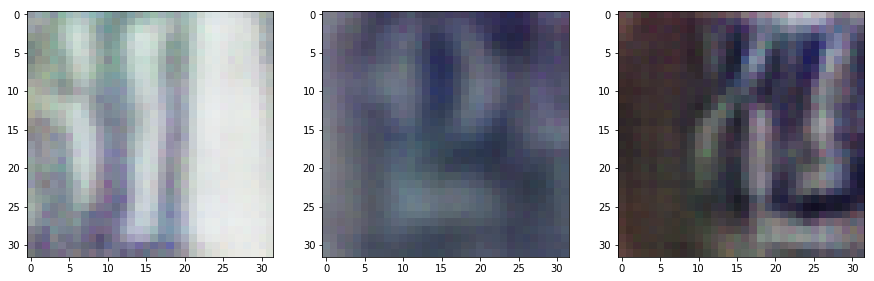

In [14]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(outputs[0, :, :, :])
plt.subplot(1, 3, 2)
plt.imshow(outputs[1, :, :, :])
plt.subplot(1, 3, 3)
plt.imshow(second_originate(outputs[2, :, :, :]))

It almost got it, and this time, Dicriminator win. GAN is very sensitive with hyperparameters, any constant should atleast experimented once.

And you can find a better image normalization, dividing by 255.0 is not a good approached, but still good enough!